In [4]:
import pandas as pd
import numpy as np
import pickle as pkl
import tensorflow as tf

import fasttext as ft
from sklearn.metrics.pairwise import cosine_similarity



import sys
sys.path.append('../')
from utils import *

In [2]:
watches = pd.read_pickle('../../data/user-level-data')
videos = pd.read_pickle('../../data/videos_raw_metadata')

In [17]:
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')
ft = fasttext.load_model('cc.en.300.bin')

def get_embedding(word):
    return ft.get_word_vector(word)


def get_embeddings(topics, tags):
    topic_embs = []
    for topic in topics:
        topic_embs.append(get_embedding(topic))
    
    tag_embs = []
    for tag in tags:
        tag_embs.append(get_embedding(tag))

    if len(topic_embs) == 0:
        topic_embs = np.zeros((1, 300))

    if len(tag_embs) == 0:
        tag_embs = np.zeros((1, 300))

    topic_embs = np.mean(np.array(topic_embs), axis=0)
    tag_embs = np.mean(np.array(tag_embs), axis=0)

    embs = np.concatenate((topic_embs, tag_embs), axis=0)

    return embs

In [18]:
watches_df = dict()

def convert(watch):
    d = dict()
    d['playing'] = watch['playing']['id']
    suggested = []
    for s in watch['suggested']:
        if s != None:
            suggested.append(s['id'])
    d['suggested'] = suggested
    d['selected'] = watch['selected']
    return d

for user in watches:
    watches_df[user] = []
    for watch in watches[user]:
        if watch['playing'] == None:
            continue
        watch = convert(watch)
        watches_df[user].append(watch)

In [20]:
history = dict()
users = list(watches_df.keys())
data = dict()

for user in users:
    if len(watches_df[user]) < 10:
        continue
    history[user] = watches_df[user][:10]

    for watch in watches_df[user][10:]:
        if watch['selected'] != None:
            if user not in data:
                data[user] = []
            data[user].append(watch)

for user in list(history.keys()):
    if user not in data:
        history.pop(user)

In [21]:
for user in history:
    history[user] = [s['playing'] for s in history[user]]
    history[user] = [get_topic_vector(s) for s in history[user]]
    history[user] = np.array(history[user]).mean(axis=0)

In [12]:
from collections import Counter


all_topics = []
all_tags = []

for video in videos:
    video = videos[video]
    
    try:
        topics = video['topicDetails']['topicCategories']
        topics = [topic.split('/')[-1].lower() for topic in topics]
    except:
        topics = []

    all_topics += topics
    
    try:
        tags = video['snippet']['tags']
        tags = [tag.lower() for tag in tags]
    except:
        tags = []

    all_tags += tags

all_topics = list(set(all_topics))

atc = Counter(all_tags)
atc = pd.DataFrame.from_dict(atc, 'index', columns=['count'])
atc = atc.sort_values(['count'], ascending=False).head(5000)
all_tags = list(atc.index)

def get_one_hot_vector(topics, tags):
    oh_topics = np.zeros(len(all_topics))
    for topic in topics:
        oh_topics[all_topics.index(topic)] = 1
        
    oh_tags = np.zeros(len(all_tags))
    for tag in tags:
        if tag in all_tags:
            oh_tags[all_tags.index(tag)] = 1
        
    oh = np.concatenate([oh_topics , oh_tags])
    
    return oh


def get_topic_vector(video):
    video = videos[video]
    try:
        topics = video['topicDetails']['topicCategories']
        topics = [topic.split('/')[-1].lower() for topic in topics]
    except:
        topics = []

    try:
        tags = video['snippet']['tags']
        tags = [tag.lower() for tag in tags]
    except:
        tags = []

    return get_embeddings(topics, tags)


In [22]:
SG, P, SX, H = [], [], [], []
Y = []

topic_vectors = dict()

for user in tqdm(data):
    user_history = history[user]
    user_history = np.concatenate([user_history, [0]])
    for watch in data[user]:
        
        playing = watch['playing']
        selected = watch['selected']
        upnext = watch['suggested'][:15]

        if playing not in videos or selected not in videos or any([s not in videos for s in watch['suggested']]):
            continue
        if len(watch['suggested']) < 15:
            continue


        playing = get_topic_vector(watch['playing'])
        playing = np.concatenate([playing, [0]])

        suggesteds = []
        
        for i, s in enumerate(upnext):
            if s not in topic_vectors:
                topic_vectors[s] = get_topic_vector(s)
            sv = topic_vectors[s]
            sv = np.concatenate([sv, [i]])
            suggesteds.append(sv)
        
        suggesteds = np.array(suggesteds)
        suggesteds = np.mean(suggesteds, axis=0)

        for i, s in enumerate(upnext):
            selected = watch['selected']

            if s == selected:
                y = 1
            else:
                y = 0

            sv = topic_vectors[s]

            sv = np.concatenate([sv, [i]])
            SG.append(suggesteds)
            P.append(playing)
            SX.append(sv)
            H.append(user_history)
            Y.append(y)

  0%|          | 0/1266 [00:00<?, ?it/s]

In [10]:
# [SG, P, SX, H, Y] = pkl.load(open('temp-SG_P_SX_H_Y.pkl', 'rb'))


In [23]:
SG = np.array(SG)
P = np.array(P)
SX = np.array(SX)
H = np.array(H)
Y = np.array(Y)

In [24]:
from sklearn.model_selection import train_test_split

SG_train, SG_test, P_train, P_test, SX_train, SX_test, H_train, H_test, Y_train, Y_test = train_test_split(SG, P, SX, H, Y, test_size=0.2, random_state=42)

In [25]:
pos = Y.sum()
neg = len(Y) - pos
total = neg + pos
w0 = (1 / neg) * (total / 2.0)
w1 = (1 / pos) * (total / 2.0)
class_weights = {0:w0, 1:w1}
class_weights

{0: 0.5345587128726417, 1: 7.734065716547902}

In [14]:
# pkl.dump([SG, P, SX, H, Y], open('temp-SG_P_SX_H_Y.pkl', 'wb'))

In [26]:
from tensorflow import keras
from keras import Model
from keras.models import Sequential
from keras.metrics import AUC, BinaryAccuracy
from keras.layers import Dense, Dropout, Flatten, Concatenate, Input
from tensorflow.keras.optimizers import SGD

In [28]:
SX.shape

(234435, 601)

In [30]:
P.shape

(234435, 601)

In [34]:
DP = 0.2

suggested_tensor = Input(shape=[601])
playing_tensor = Input(shape=[601])
selected_tensor = Input(shape=[601])
history_tensor = Input(shape=[601])


sg_dense = Dense(256, activation='relu')(suggested_tensor)
sg_dense = Dropout(DP)(sg_dense)
sg_dense = Dense(128, activation='relu')(sg_dense)
sg_dense = Dropout(DP)(sg_dense)
sg_dense = Dense(64, activation='relu')(sg_dense)
sg_dense = Dropout(DP)(sg_dense)
sg = Flatten()(sg_dense)

pl_dense = Dense(256, activation='relu')(playing_tensor)
pl_dense = Dropout(DP)(pl_dense)
pl_dense = Dense(128, activation='relu')(pl_dense)
pl_dense = Dropout(DP)(pl_dense)
pl_dense = Dense(64, activation='relu')(pl_dense)
pl_dense = Dropout(DP)(pl_dense)
pl = Flatten()(pl_dense)

sl_dense = Dense(256, activation='relu')(selected_tensor)
sl_dense = Dropout(DP)(sl_dense)
sl_dense = Dense(128, activation='relu')(sl_dense)
sl_dense = Dropout(DP)(sl_dense)
sl_dense = Dense(64, activation='relu')(sl_dense)
sl_dense = Dropout(DP)(sl_dense)
sl = Flatten()(sl_dense)

hl_dense = Dense(256, activation='relu')(history_tensor)
hl_dense = Dropout(DP)(hl_dense)
hl_dense = Dense(128, activation='relu')(hl_dense)
hl_dense = Dropout(DP)(hl_dense)
hl_dense = Dense(64, activation='relu')(hl_dense)
hl_dense = Dropout(DP)(hl_dense)
hl = Flatten()(hl_dense)

merged = Concatenate()([sg, pl, sl, hl])
# x = Dense(1025, activation='relu')(merged)
# x = Dropout(DP)(x)
x = Dense(256, activation='relu')(merged)
x = Dropout(DP)(x)
x = Dense(64, activation='relu')(merged)

final = Dense(1, activation='sigmoid')(x)


METRICS = [BinaryAccuracy(name='accuracy'),
           AUC(name='auc'),       
           keras.metrics.AUC(name='prc', curve='PR')]

model = Model(inputs=[suggested_tensor, playing_tensor, selected_tensor, history_tensor], outputs=final)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

In [35]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 601)]                0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 601)]                0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 601)]                0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 601)]                0         []                            
                                                                                            

In [36]:
model.fit([SG_train, P_train, SX_train, H_train], Y_train,
            epochs=30,
            batch_size=32,
            validation_split=0.2, 
            class_weight=class_weights)

Epoch 1/30
2345/2345 [==============================] - 23s 8ms/step - loss: 0.5820 - accuracy: 0.7584 - auc: 0.7606 - val_loss: 0.5546 - val_accuracy: 0.7541 - val_auc: 0.7625
Epoch 2/30
2345/2345 [==============================] - 19s 8ms/step - loss: 0.5756 - accuracy: 0.7528 - auc: 0.7655 - val_loss: 0.5248 - val_accuracy: 0.7971 - val_auc: 0.7632
Epoch 3/30
2345/2345 [==============================] - 19s 8ms/step - loss: 0.5738 - accuracy: 0.7610 - auc: 0.7679 - val_loss: 0.5842 - val_accuracy: 0.7584 - val_auc: 0.7622
Epoch 4/30
2345/2345 [==============================] - 19s 8ms/step - loss: 0.5718 - accuracy: 0.7600 - auc: 0.7695 - val_loss: 0.6027 - val_accuracy: 0.7527 - val_auc: 0.7603
Epoch 5/30
2345/2345 [==============================] - 19s 8ms/step - loss: 0.5706 - accuracy: 0.7589 - auc: 0.7709 - val_loss: 0.5748 - val_accuracy: 0.7051 - val_auc: 0.7627
Epoch 6/30
2345/2345 [==============================] - 17s 7ms/step - loss: 0.5684 - accuracy: 0.7510 - auc: 0.773

In [37]:
#f1 score
from sklearn.metrics import classification_report

y_pred_keras = model.predict([SG_test, P_test, SX_test, H_test]).ravel()
y_pred = np.round(y_pred_keras)
print(classification_report(Y_test, y_pred))

1466/1466 [==============================] - 2s 961us/step
              precision    recall  f1-score   support

           0       0.97      0.74      0.84     43834
           1       0.14      0.62      0.23      3053

    accuracy                           0.73     46887
   macro avg       0.55      0.68      0.53     46887
weighted avg       0.91      0.73      0.80     46887



In [ ]:
y_pred_kes

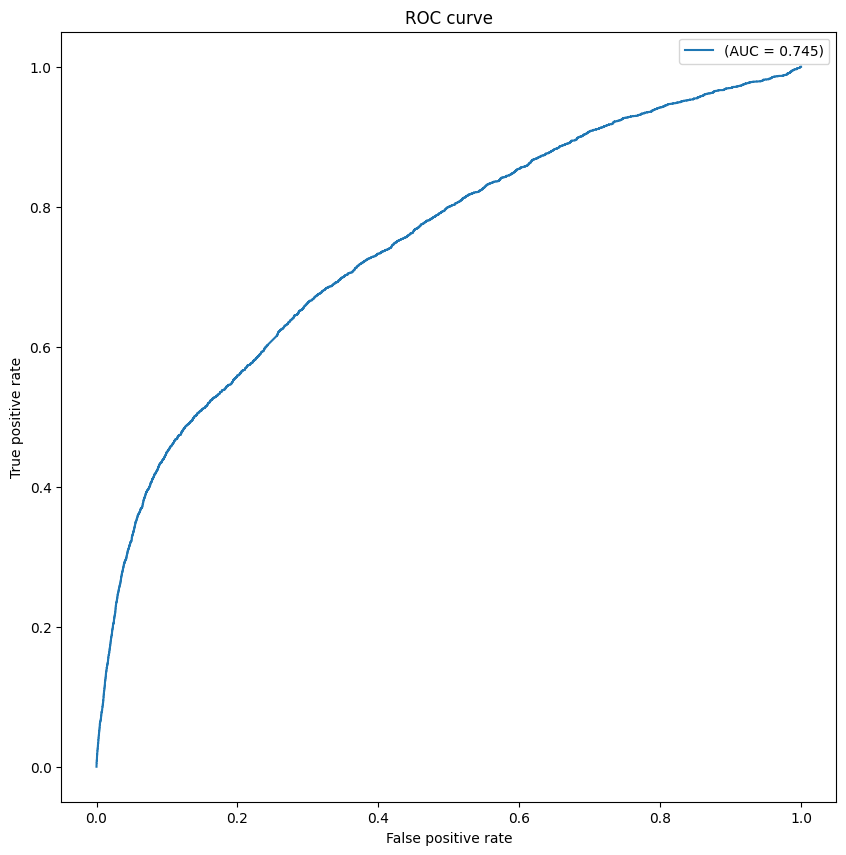

In [38]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# y_pred_keras = model.predict([SG_test, P_test, SX_test, H_test]).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(figsize=(10,10))
plt.plot(fpr_keras, tpr_keras, label='(AUC = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
